In [2]:
import numpy as np
import matplotlib.pyplot as plt
from worm_env import *

In [204]:
traj = np.load('Data/Qtab_i0_32.npz',allow_pickle=True)

In [194]:
traj_tot = {}
for i in range(40):
    traj = np.load('Data/Qtab_i0_'+str(i)+'.npz',allow_pickle=True)
    add_to_traj(traj_tot,traj)

#np.savez('Data/Qtab_i0.npz',**traj_tot,allow_pickle=True)

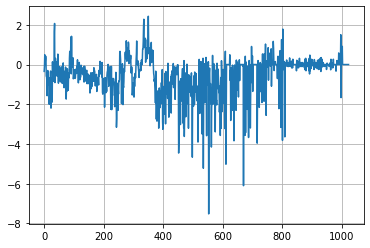

In [205]:
plt.plot(traj['reward'])
plt.grid();

In [190]:
np.sum(traj['reward'])/300

0.30738198983297027

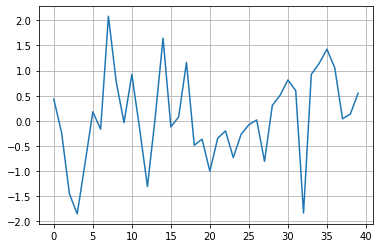

In [203]:
av_rew = [np.sum(traj_tot['reward'][i])/300 for i in range(40)]
plt.plot(av_rew)
plt.grid();

In [83]:
traj = traj['loc']

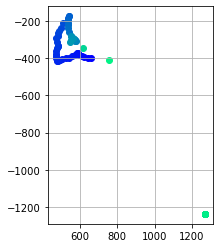

In [84]:
fig,ax = plt.subplots(1)
#fig.set_size_inches((12,12))
NPOINTS = traj[::10,:].shape[0]
track = traj[::10,:]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,0],-track[i,1])
    ax.set_aspect('equal','box')
ax.grid();

In [113]:
class QTab_Agent():
    """
    General Q table agent.
    """
    def __init__(self,SA_discrete=(12,12,2),alpha=0.01,gamma=0.5,eps=0.1):
        # SA_discrete is (state0, state1, action) sizes
        # alpha is learning step size
        # gamma is discount factor
        # eps is the proportion of time random actions are selected
        
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.qtab = np.random.normal(scale=0.1,size=SA_discrete)
        self.obs_count = np.zeros(SA_discrete)
        
    def load(self,fname):
        chkpt = np.load(fname,allow_pickle=True)
        self.alpha = chkpt['alpha']
        self.gamma = chkpt['gamma']
        self.eps = chkpt['eps']
        
        self.qtab = chkpt['qtab']
        self.obs_count = chkpt['count']
        
    def learn(self, obs, obs_next, act, reward, DEG_STEP=30):
        # Takes obs_t, act_t, r_{t+1} and updates table if all values are valid.
        # DEG_STEP is the angle increment for discretizing states
        
        # Q table update step:
        # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
        
        if np.isnan(obs[0]) or np.isnan(obs_next[0]):
            return
        
        i_obs = self.obs2ind(obs)
        i_obs_next = self.obs2ind(obs_next)
        
        # Update rule and update count
        self.qtab[i_obs[0],i_obs[1],act] = self.qtab[i_obs[0],i_obs[1],act] + \
            self.alpha*(reward+self.gamma*np.max(self.qtab[i_obs_next[0],i_obs_next[1],:])
                  - self.qtab[i_obs[0],i_obs[1],act])
        self.obs_count[i_obs[0],i_obs[1],act] += 1
        
    def sample(self, obs):
        # Finds the best action for a given state.
        # eps of the time, returns a random choice for exploration.
        if np.isnan(obs[0]):
            return 0
        if np.random.uniform() < self.eps:
            return np.random.randint(0,2)
        i_obs = self.obs2ind(obs) 
        return np.argmax(self.qtab[i_obs[0],i_obs[1],:])
        
    def obs2ind(self,obs):
        # Maps [-180,180] to [0,11].
        # Must take valid obs (no nans)
        i_obs = np.zeros(2)
        for i in range(2):
            if obs[i]==180:
                i_obs[i] = -180
            i_obs[i] = int((obs[i]+180)/30)
        return i_obs.astype(int)
    
    def save(self,fname):
        # Saves agent as npz file with keys 'qtab' and 'count'.
        agent_dict = {
            'qtab':self.qtab,
            'count':self.obs_count,
            'eps':self.eps,
            'alpha':self.alpha,
            'gamma':self.gamma
        }
        np.savez(fname,**agent_dict)

In [163]:
agent = QTab_Agent(alpha=0.05,gamma=0.9,eps=0.1)
agent.load('Data/Qtab_i1_19_agent.npz')

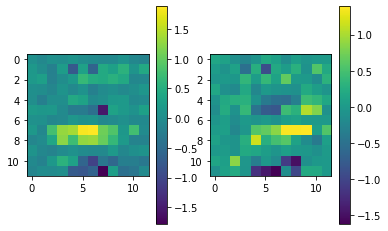

In [164]:
fig,ax = plt.subplots(1,2)
q0=ax[0].imshow(agent.qtab[:,:,0])
q1=ax[1].imshow(agent.qtab[:,:,1])
plt.colorbar(q0,ax=ax[0]);
plt.colorbar(q1,ax=ax[1]);

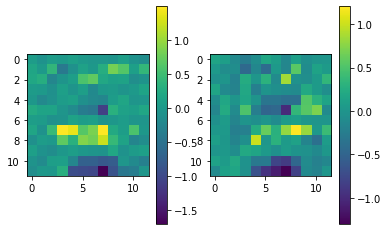

In [140]:
fig,ax = plt.subplots(1,2)
q0=ax[0].imshow(agent.qtab[:,:,0])
q1=ax[1].imshow(agent.qtab[:,:,1])
plt.colorbar(q0,ax=ax[0]);
plt.colorbar(q1,ax=ax[1]);